# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['text.usetex'] = True

def tangent(ra: float, dec: float) -> tuple[np.ndarray, np.ndarray]:
    """Returns the tangent vectors pointing to west and north.

    Args:
        ra (float): right ascension in degrees
        dec (float): declination in degrees

    Returns:
        tuple[float,float]: west and north vectors
    """
    # Convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    
    # Get sin and cos of ra and dec
    sinRa = np.sin(ra)
    cosRa = np.cos(ra)
    sinDec = np.sin(dec)
    cosDec = np.cos(dec)
    
    # Get tangent vectors
    west = np.array([sinRa, -cosRa, 0])
    north = np.array([-sinDec * cosRa, -sinDec * sinRa, cosDec])
    return west, north

## Load small data

In [2]:
data_path = 'data/match_4000710334517.csv'
data_df = pd.read_csv(data_path)

# Convert Image IDs to integers in range [0, number of images]
data_df.ImageID = pd.factorize(data_df.ImageID)[0]

# Get kappas (inverse of sigma)
data_df["kappa"] = 1 / (data_df["sigma"] ** 2)
data_df["kappa (radians)"] = 1 / ((data_df["sigma"]*np.pi/180/3600) ** 2)
data_df["log kappa (radians)"] = np.log(data_df["kappa (radians)"])

data_df.head()

,MatchID,SubID,RA,Dec,ImageID,SourceID,X,Y,Z,sigma,kappa,kappa (radians),log kappa (radians)
0,4000710334517,0,269.749758,-29.186608,0,4001061039486,-0.003813,-0.873028,-0.487656,0.03655,748.557635,3.184751e+13,31.091980
1,4000710334517,0,269.749758,-29.186608,1,4001212780699,-0.003814,-0.873028,-0.487656,0.06405,243.759586,1.037079e+13,29.970015
2,4000710334517,0,269.749758,-29.186608,1,4001212780710,-0.003812,-0.873028,-0.487656,0.03850,674.650059,2.870310e+13,30.988026
3,4000710334517,0,269.749758,-29.186608,2,4001120525362,-0.003813,-0.873028,-0.487656,0.03395,867.601807,3.691227e+13,31.239565
4,4000710334517,0,269.749758,-29.186608,3,4001152086466,-0.003813,-0.873028,-0.487656,0.01605,3881.949811,1.651582e+14,32.737925


## Convert to 2D coordinates
Do dot product with tangent vectors (north and west) to get x and y (in radians) Blur is the same because it's the same instrument. 

In [3]:
from collections import defaultdict

counts = defaultdict(int)
for row in data_df.itertuples():
    counts[(row.RA, row.Dec)] += 1

# Calculate center of all objects in Ra and Dec
centers_ra_decs = list(counts.keys())
num_counts = sum(counts.values())
center_ra = sum(c[0] * counts[c] for c in centers_ra_decs) / num_counts
center_dec = sum(c[1] * counts[c] for c in centers_ra_decs) / num_counts

In [4]:
# Convert to west/north coordinates
center_west, center_north = tangent(center_ra, center_dec)

data_df["coord1 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df["coord2 (arcseconds)"] = (data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

## Cluster

In [5]:
from scipy import spatial

def neg_log_bayes(data_df: pd.DataFrame, labels: list[int]) -> float:
    """ Calculate negative log bayes factor using the given labels.

    Args:
        data_df (pd.DataFrame): Data dataframe with coordinates and uncertainties
        labels (list[int]): integer array of labels

    Returns:
        float: negative log bayes factor
    """
    out = 0
    data_df["labels"] = labels

    for i in range(max(labels) + 1):
        # filter data to sources labeled to i
        data_labeled = data_df[data_df.labels == i]

        # get 2D coordinates of sources
        # coords = data_labeled[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
        coord1 = data_labeled["coord1 (arcseconds)"]
        coord2 = data_labeled["coord2 (arcseconds)"]
        weights = data_labeled["kappa"]

        # Get centroid
        centroid1 = (coord1 * weights).sum() / weights.sum()
        centroid2 = (coord2 * weights).sum() / weights.sum()

        # Get number of sources
        num_sources = data_labeled.shape[0]

        # Get kappa sums
        sum_ln_kappa_rad = data_labeled["log kappa (radians)"].sum()
        ln_sum_kappa_rad = np.log(data_labeled["kappa (radians)"].sum())
        sum_kappa = data_labeled["kappa"].sum()

        # Get sum of pairwise distances between all sources
        sum_of_square_dist = np.sum(np.power(coord1 - centroid1, 2) + np.power(coord2 - centroid2, 2))

        # Divide by 4 * sum of kappas
        double_sum = sum_of_square_dist / 4

        # Add up all terms
        out += (1 - num_sources) * np.log(2) - sum_ln_kappa_rad + ln_sum_kappa_rad + double_sum

    # Remove the label column
    del data_df["labels"]

    return out

In [6]:
for i in range(max(data_df.ImageID)):
    data_img = data_df[data_df.ImageID == i]
    counts = data_img.SourceID.value_counts()

    for c in counts:
        if c > 1:
            print(f"Image {i} has two sources clustered together")

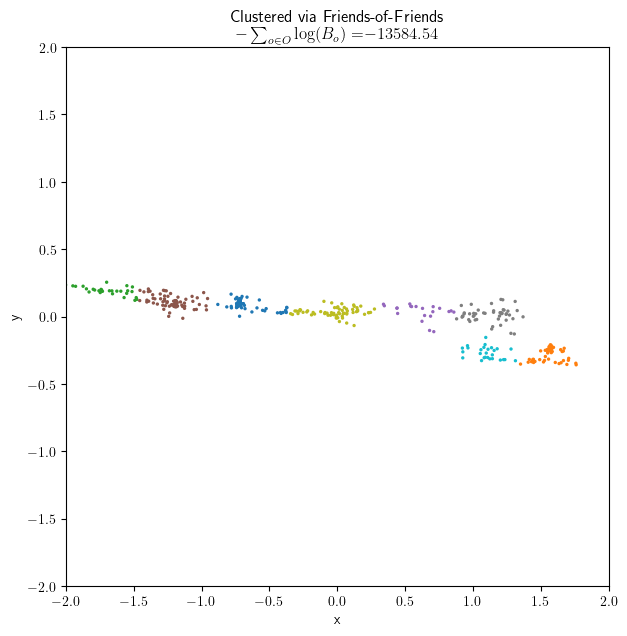

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = data_df.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df, list(data_df.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### KMeans

In [33]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

def run_kmeans(data_df, min_k, max_k):
    coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
    weights = data_df["kappa"]

    best_labels = None
    best_k = 0
    best_bayes = np.Inf

    for k in tqdm(range(min_k,max_k)):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init = 100).fit(X = coords, sample_weight=weights)

        bayes = neg_log_bayes(data_df, kmeans.labels_)

        if bayes < best_bayes:
            best_bayes = bayes
            best_labels = kmeans.labels_
            best_k = k
    return best_labels, best_k, best_bayes

100%|███████████████████████████████████████████| 49/49 [00:27<00:00,  1.77it/s]


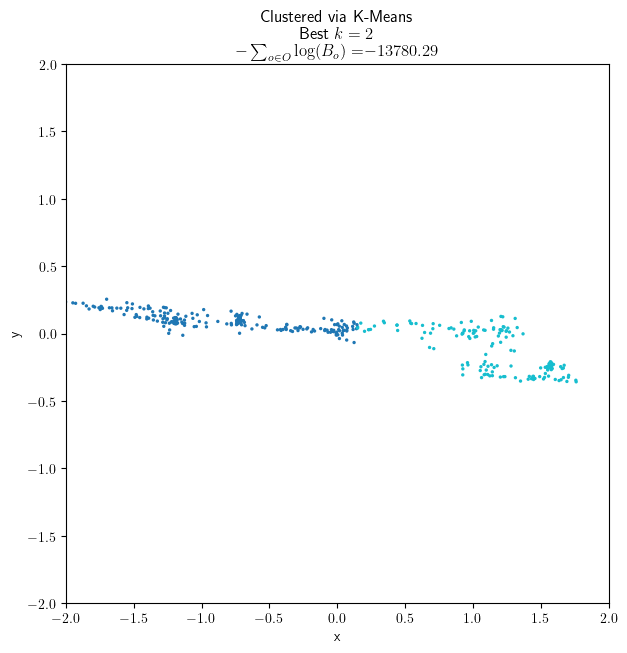

In [34]:
best_labels, best_k, best_bayes = run_kmeans(data_df, 1,50)

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab10')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

### COP-KMeans

In [17]:
from cop_kmeans import cop_kmeans
import itertools

def run_cop_kmeans(data_df: pd.DataFrame, min_k = 1, max_k = 50):
    """

    Args:
        data_df (pd.DataFrame): dataframe with coordinates, kappas, etc.

    Returns:
        tuple: labels, k, and negative log bayes factor
    """
    coords = data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]].to_numpy()
    weights = data_df["kappa"]

    # Create cannot-links (list of tuples)
    cannot_link_dict: dict[int,list[int]] = dict()

    for i in range(max(data_df.ImageID)):
        cannot_link_dict[i] = data_df[data_df.ImageID == i].index.to_list()

    cannot_link = []

    for l in cannot_link_dict.values():
        for comb in itertools.combinations(l,2):
            cannot_link.append(comb)

    best_labels = None
    best_k = 0
    best_bayes = np.Inf

    for k in tqdm(range(min_k,max_k)):
        clusters, centers = cop_kmeans(dataset=coords, initialization="kmpp", k=k, ml=[],cl=cannot_link, sample_weights=weights)
        
        if clusters is None:
            continue

        bayes = neg_log_bayes(data_df, clusters)

        if bayes < best_bayes:
            best_bayes = bayes
            best_labels = clusters
            best_k = k
    
    return best_labels, best_k, best_bayes

100%|███████████████████████████████████████████| 49/49 [00:17<00:00,  2.81it/s]


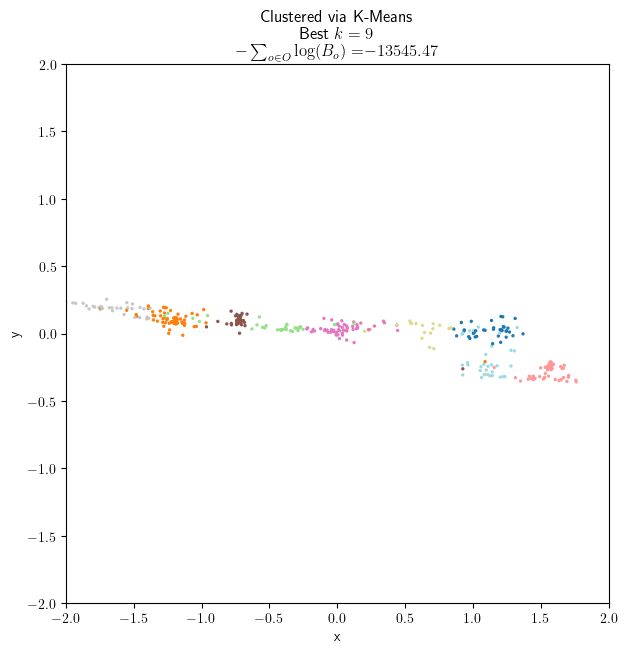

In [18]:
best_labels, best_k, best_bayes = run_cop_kmeans(data_df, 1, 50)

plt.figure(figsize=(7,7))
plt.scatter(data_df['coord1 (arcseconds)'],
            data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()

## Big Data

In [11]:
big_data_path = "big_data/MyHDF_jacobf18_0.csv"
big_data_df = pd.read_csv(big_data_path)

# Convert Image IDs to integers in range [0, number of images]
big_data_df.ImageID = pd.factorize(big_data_df.ImageID)[0]

# Get kappas (inverse of sigma)
big_data_df["kappa"] = 1 / (big_data_df.Sigma ** 2)
big_data_df["kappa (radians)"] = 1 / ((big_data_df.Sigma*np.pi/180/3600) ** 2)
big_data_df["log kappa (radians)"] = np.log(big_data_df["kappa (radians)"])

big_data_df.head()

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804


### Convert to 2D Coordinates

In [12]:
# Get center of data points
center_ra = big_data_df.RA.mean()
center_dec = big_data_df.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

big_data_df["coord1 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
big_data_df["coord2 (arcseconds)"] = (big_data_df[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

big_data_df

,ImageID,JobID,MatchID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,0,35306,4211611957,4000916189528,0.456528,-0.182370,-0.870817,0.02900,338.225364,-60.552930,1189.060564,5.058878e+13,31.554751,10.930064,-5.757109
1,0,35306,4211611904,4000916189529,0.456427,-0.182594,-0.870823,0.01000,338.196765,-60.553629,10000.000000,4.254517e+14,33.684173,61.544402,-8.301104
2,0,35306,4211611842,4000916189530,0.456499,-0.182411,-0.870824,0.01875,338.219733,-60.553715,2844.444444,1.210174e+14,32.426955,20.895535,-8.587093
3,0,35306,4211611919,4000916189532,0.456505,-0.182411,-0.870821,0.01110,338.219887,-60.553379,8116.224123,3.453061e+14,33.475452,20.623653,-7.377742
4,0,35306,4211612082,4000916189535,0.456455,-0.182547,-0.870819,0.02810,338.203047,-60.553056,1266.448045,5.388125e+13,31.617804,50.428467,-6.230797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500,55,35306,4600995538,4600995538,0.456473,-0.182048,-0.870914,0.10680,338.256965,-60.564915,87.671305,3.729991e+12,28.947427,-46.624523,-46.174268
60501,55,35306,4600995523,4600995523,0.456340,-0.182410,-0.870908,0.02490,338.211995,-60.564248,1612.877199,6.862014e+13,31.859607,32.937911,-43.786583
60502,55,35306,4600995488,4600995488,0.456445,-0.182132,-0.870911,0.07570,338.246640,-60.564574,174.505139,7.424351e+12,29.635786,-28.356915,-44.944932
60503,55,35306,4600995480,4600995480,0.456368,-0.182323,-0.870911,0.14380,338.222590,-60.564618,48.359547,2.057465e+12,28.352496,14.191576,-45.110163


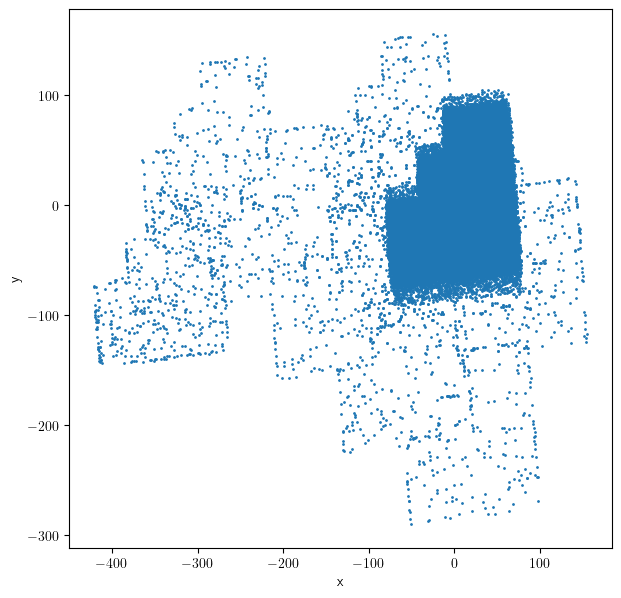

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=1.0)
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.18s/it]


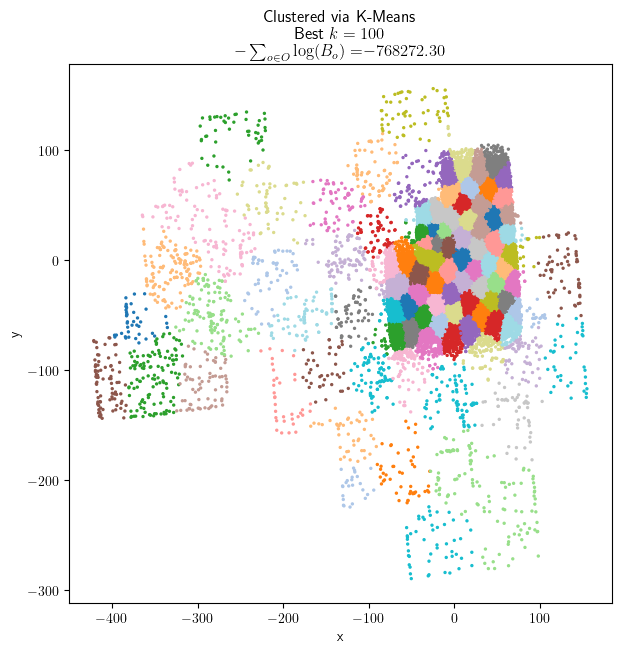

In [16]:
from sklearn.cluster import KMeans
from tqdm import tqdm
from collections import defaultdict

best_labels = None
best_k = 0
best_bayes = np.Inf

coords = big_data_df[["coord1 (arcseconds)", "coord2 (arcseconds)"]]
weights = big_data_df["kappa"]

for k in tqdm(range(100,101)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X = coords, sample_weight=weights)

    bayes = neg_log_bayes(big_data_df, kmeans.labels_)

    if bayes < best_bayes:
        best_bayes = bayes
        best_labels = kmeans.labels_
        best_k = k

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

## COP-Kmeans

In [ ]:
best_labels, best_k, best_bayes = run_cop_kmeans(big_data_df, 100,101)

plt.figure(figsize=(7,7))
plt.scatter(big_data_df['coord1 (arcseconds)'],
            big_data_df['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

## Match 

In [37]:
data_df_2 = pd.read_csv('data/match_6000160767697.csv')

# Convert Image IDs to integers in range [0, number of images]
data_df_2.ImageID = pd.factorize(data_df_2.ImageID)[0]

# Get kappas (inverse of sigma)
data_df_2["kappa"] = 1 / (data_df_2["Sigma"] ** 2)
data_df_2["kappa (radians)"] = 1 / ((data_df_2["Sigma"]*np.pi/180/3600) ** 2)
data_df_2["log kappa (radians)"] = np.log(data_df_2["kappa (radians)"])

# Get center of data points
center_ra = data_df_2.RA.mean()
center_dec = data_df_2.Dec.mean()

center_west, center_north = tangent(center_ra, center_dec)

data_df_2["coord1 (arcseconds)"] = (data_df_2[["X", "Y", "Z"]] @ center_west) * 180 * 3600 / np.pi
data_df_2["coord2 (arcseconds)"] = (data_df_2[["X", "Y", "Z"]] @ center_north) * 180 * 3600 / np.pi

data_df_2

,MatchID,Level,SubID,ImageID,SourceID,X,Y,Z,Sigma,RA,Dec,kappa,kappa (radians),log kappa (radians),coord1 (arcseconds),coord2 (arcseconds)
0,6000160767697,2,0,0,6000160767697,-0.770668,-0.025419,-0.63673,0.02678,181.889145,-39.548367,1394.372724,5.932383e+13,31.714032,0.057720,-0.070164
1,6000160767697,2,0,1,6000200049984,-0.770668,-0.025419,-0.63673,0.02795,181.889145,-39.548367,1280.077715,5.446112e+13,31.628508,0.054930,-0.066913
2,6000160767697,2,0,2,6000509549833,-0.770668,-0.025419,-0.63673,0.02795,181.889097,-39.548468,1280.077715,5.446112e+13,31.628508,0.062785,-0.071690
3,6000160767697,2,0,3,6000443790714,-0.770668,-0.025419,-0.63673,0.02847,181.889097,-39.548466,1233.743970,5.248985e+13,31.591641,0.063094,-0.073348
4,6000160767697,2,0,4,6000510780386,-0.770668,-0.025419,-0.63673,0.03211,181.889148,-39.548365,969.883071,4.126384e+13,31.351008,0.055842,-0.069751
5,6000160767697,2,0,5,6000332395766,-0.770668,-0.025419,-0.63673,0.02925,181.889099,-39.548469,1168.821682,4.972772e+13,31.537584,0.063280,-0.071242
6,6000160767697,2,1,6,6000179832048,-0.770668,-0.025420,-0.63673,0.00828,181.889168,-39.548429,14586.105634,6.205683e+14,34.061657,-0.115376,-0.009996
7,6000160767697,2,1,7,6000435667141,-0.770668,-0.025420,-0.63673,0.00804,181.889172,-39.548426,15469.914258,6.581701e+14,34.120485,-0.116995,-0.009337
8,6000160767697,2,1,8,6000274900085,-0.770668,-0.025420,-0.63673,0.00868,181.889163,-39.548418,13272.737923,5.646909e+14,33.967300,-0.116098,-0.011518
9,6000160767697,2,1,9,6000295587793,-0.770668,-0.025420,-0.63673,0.01472,181.889189,-39.548406,4615.134521,1.963517e+14,32.910928,-0.085463,-0.034497


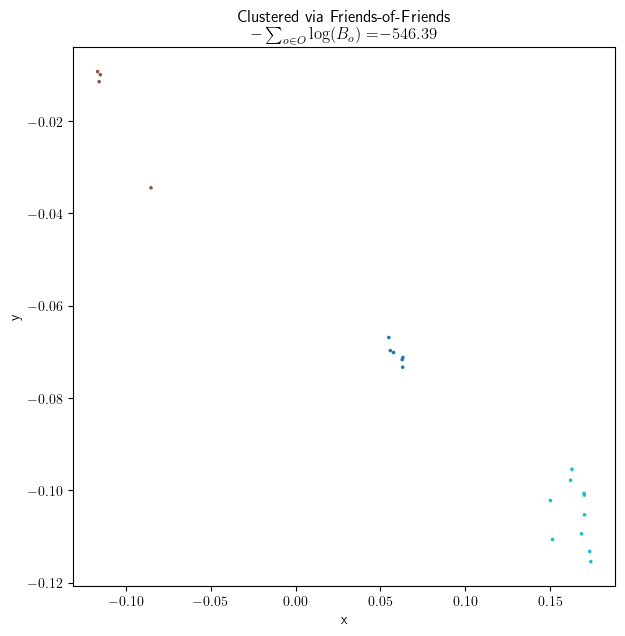

In [38]:
plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.5, c = data_df_2.SubID, cmap='tab10')
plt.title("Clustered via Friends-of-Friends\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes(data_df_2, list(data_df_2.SubID)):.2f}$")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 76.09it/s]


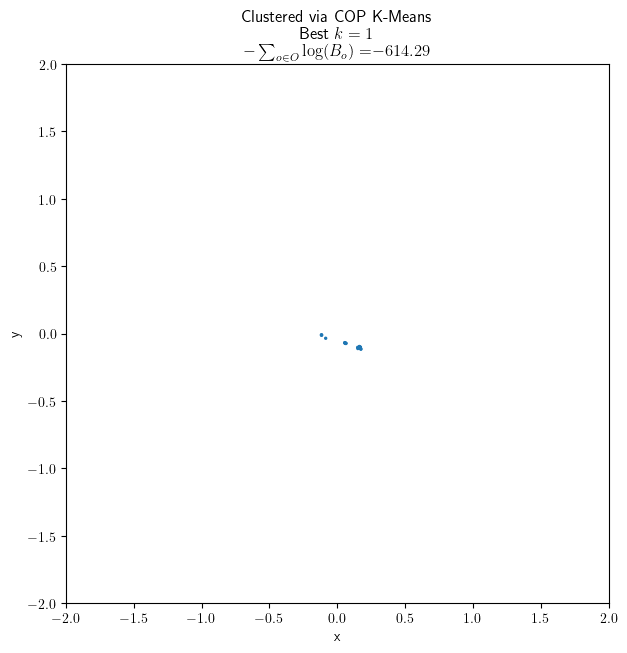

In [35]:
best_labels, best_k, best_bayes = run_cop_kmeans(data_df = data_df_2, min_k = 1, max_k = data_df_2.shape[0])

plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via COP K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()

100%|███████████████████████████████████████████| 19/19 [00:05<00:00,  3.77it/s]


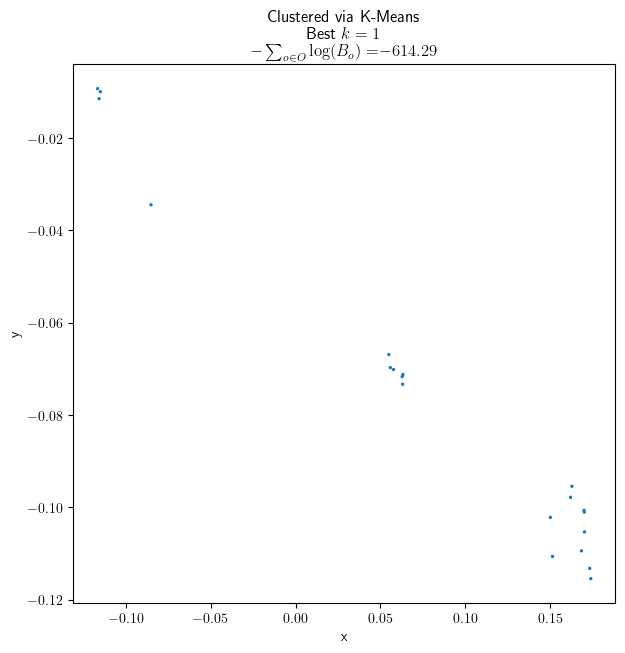

In [36]:
best_labels, best_k, best_bayes = run_kmeans(data_df = data_df_2, min_k = 1, max_k = data_df_2.shape[0])

plt.figure(figsize=(7,7))
plt.scatter(data_df_2['coord1 (arcseconds)'],
            data_df_2['coord2 (arcseconds)'],
            s=2.0, c = best_labels, cmap='tab20')
plt.title("Clustered via K-Means\n"
          f"Best $k={best_k}$\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${best_bayes:.2f}$")
plt.xlabel('x')
plt.ylabel('y')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.show()